In [1]:
clear all;

global ipynb = 'tic-tac-toe-alt';

source('clearest-nn.m');
source('utils-logging.m');
source('utils-training.m');

log2file(tmp('log'));

##########################################


ans = THE CLEAREST NEURAL NETWORK FRAMEWORK BY UNDWAD
OpenJDK 64-Bit Server VM warning: Archived non-system classes are disabled because the java.system.class.loader property is specified (value = "org.octave.OctClassLoader"). To use archived non-system classes, this property must be not be set


In [2]:
### TIC-TAC-TOE GAME ###

function oh = game2onehot(s) 
    s = s(:);
    oh = onehots(s', [1,2])(:);
%     oh = [ s == 0; s == 1; s == 2 ];
end

function p = other(p)
    p = mod(p,2)+1;
end

function p = player(s,a)
    if nargin == 1
        n = nnz(s);
        p = mod(n,2) + 1;
    elseif nargin == 2
        [y,x] = ind2sub([3,3], a);
        p     = s(y,x);
    end
end

function s = game(s,a)
    if nargin == 0
        s = zeros(3,3);   
    elseif nargin == 2 && any(actions(s) == a)
        [y,x]  = ind2sub([3,3], a);
        s(y,x) = player(s);
    end
end

function aaa = actions(s)
    [y,x] = find(s == 0);
    n     = length(y);
    aaa   = zeros(1,n);
    for i = 1:n
        aaa(i) = sub2ind([3,3], y(i), x(i));
    end
end

function yes = isover(s)
    yes = nnz(s) == 9;
end

function win = iswin(s,a)
    winner = -1;
    p      = player(s,a);
    [y,x]  = ind2sub([3,3], a);
    row    = all(s(y, 1:3) == p);
    col    = all(s(1:3, x) == p);
    diag1  = (x-y == 0) && all(s(1:4:9) == p); 
    diag2  = (x+y == 4) && all(s(3:2:7) == p); 
    win    = row || col || diag1 || diag2; 
end

function [winner,s] = play1(pi1, pi2=pi1)
    pi = {pi1, pi2};
    s  = game();
    while true
        p = player(s);
        a = pi{p}(s);
        s = game(s, a);
        if iswin(s,a)
            winner = p;
            break;
        end
        if isover(s)
            winner = 0;
            break;
        end    
    end
end

function [wins,draws] = play(n, pi1, pi2=pi1)
    printlog('playing %d times %s vs %s\n', n, func2str(pi1), func2str(pi2));
    wins  = zeros(1,2);
    draws = 0;
    for i = 1:n
        winner = play1(pi1, pi2);
        if winner > 0
            wins(winner) += 1;
        else
            draws += 1;
        end
    end
    printvar('wins');
    printvar('draws');
end

function a = randompolicy(s)
    aaa = actions(s);
    a   = pick(aaa);
end

[winner,s] = play1(@randompolicy, @randompolicy)
oh = game2onehot(s)'
play(100, @randompolicy);


winner =  1
s =

   1   0   1
   2   1   2
   1   2   0

oh =

   1   0   0   1   1   0   0   0   1   0   0   1   1   0   0   1   0   0

playing 100 times randompolicy vs randompolicy
wins = [64 22]
draws = 14


<img align="left" src="assets/reinforce.png">
<img align="left" src="assets/reinforce-baseline.png">

qmodel.num_p = 1701
playing 100 times randompolicy vs randompolicy
wins = [59 29]
draws = 12
playing 100 times randompolicy vs stochastic_policy
wins = [56 32]
draws = 12
playing 100 times randompolicy vs deterministic_policy
wins = [55 42]
draws = 3

datestr(starts_at) = 13-Jun-2020 11:47:14

player 2, episode 94 of 100, gradnorm 1.044340, updratio 0.109441, wins [47 32], error 0.036444 ↓, ratio 0.680851 ↓
datestr(ends_at) = 13-Jun-2020 11:47:21
duration = [0 0 0 0 0 6.975516]

playing 100 times randompolicy vs stochastic_policy
wins = [55 34]
draws = 11
playing 100 times randompolicy vs deterministic_policy
wins = [58 29]
draws = 13


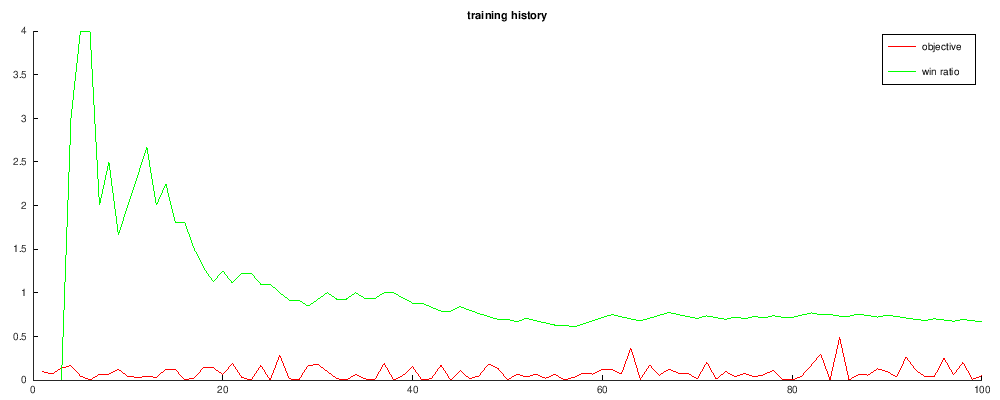

In [3]:
### Q-LEARNING WITH NEURAL NETWORK FUNCTION APPROXIMATION ###

global qmodel tau gamma;

function a = stochastic_policy(s)
    global qmodel;
    x       = game2onehot(s);
    [~,qqq] = forward(qmodel, x);
    aaa     = actions(s);
    qq      = qqq(aaa);
    i       = find(mnrnd(1, softmax(qq)));
    a       = aaa(i);
end

function a = deterministic_policy(s)
    global qmodel;
    global qmodel;
    x       = game2onehot(s);
    [~,qqq] = forward(qmodel, x);
    aaa     = actions(s);
    qq      = qqq(aaa);
    [~,i]   = max(qq);
    a       = aaa(i);
end

function q = qnnestimate(s)
    global qmodel;
    oh      = game2onehot(s);
    [~,qqq] = forward(qmodel, oh);
    q       = mean(qqq);
end

function s = start(agent)
    s = game();
    if agent == 2
        a = randompolicy(s);
        s = game(s, a); 
    end
end

function [s, reward, winner] = move(agent, s, a)
    s = game(s, a);            # learning player moves
    if iswin(s, a)             # learning player wins
        reward = 1;
        winner = agent;
    elseif isover(s)           # draw
        reward = 0;
        winner = 0;
    elseif player(s) == agent  # invalid move
        error('invalid move');
    else                       # continue
        a = randompolicy(s);   
        s = game(s, a);        # other player moves
        if iswin(s, a)         # other player wins
            reward = -1;
            winner = player(s, a);
        elseif isover(s)       # draw
            reward = 0;
            winner = 0;
        else                   # continue
            reward = 0;
            winner = [];
        end  
    end  
end

global delta_error_signs;

function [winner,err] = episode(agent)
    global qmodel tau gamma;
    winner = [];     # draw: 0, players: 1,2
    X = zeros(18,9); # states as onehot vectors
    P = zeros(9,9);  # valid action probs
    A = zeros(1,9);  # selected actions
    Y = zeros(9,9);  # targets (rewards)
    n = 0;           # number of moves
    s = start(agent);
    do
        x       = game2onehot(s);
        [~,qqq] = forward(qmodel, x);
        aaa     = actions(s);
        pp      = softmax(qqq(aaa) / tau);
        a       = aaa(find(mnrnd(1, pp)));
        ppp     = setsome(zeros(9, 1), pp, aaa);
        [s, reward, winner] = move(agent, s, a);
        n     += 1;
        X(:,n) = x;
        P(:,n) = ppp;
        A(:,n) = a;
        y      = setsome(zeros(9, 1), reward, a); 
        Y(:,n) = y;
    until !isempty(winner);
%     X
%     P
%     A
%     Y
    for i = n-1:-1:1
        a       = A(i);
        next_y  = sum(P(:,i+1) .* Y(:,i+1));
        Y(a,i) += gamma*next_y;
    end
    X              = X(:, 1:n);
    Y              = Y(:, 1:n);
%     Y
    [qmodel,Z]     = forward(qmodel, X);
%     Z
    Y              = Z .* (Y == 0) .+ Y;
%     Y
    E              = cost(qmodel, Z, Y);
%     E
    dE             = gradient(qmodel, Z, Y);
%     dE
    [qmodel,ggg,~] = backward(qmodel, Z, dE);
    [qmodel,ggg]   = optimize_gradient(qmodel, ggg, 1);
    new_qmodel     = update(qmodel, ggg);
    err            = mean(E);
    
    [~,Z]          = forward(new_qmodel, X);
    Y              = Z .* (Y == 0) .+ Y;
    E              = cost(new_qmodel, Z, Y);
    delta          = mean(E) - err;

    if delta < 0
        qmodel = new_qmodel;
    end
    
    global delta_error_signs;
    delta_error_signs(sign(delta)+2) += 1;
end

function ratio = iteration(p, n, eps=1e-8)
    global qmodel;
    ERROR = zeros(1,n);
    RATIO = zeros(1,n);
    wins  = [0 0];
    for t = 1:n
        [winner,err] = episode(p);
        if winner > 0 
            wins(winner) += 1; 
        end
        if nnz(wins) == 2
            ratio = wins(p) / wins(other(p));
        else
            ratio = 0;
        end
        ERROR(t) = err;
        RATIO(t) = ratio;
        if t > 1 
            edir = sign(err   - ERROR(t-1));
            rdir = sign(ratio - RATIO(t-1));
        else
            edir = 0;
            rdir = 0;
        end
        gradnorm = getunit(qmodel.optimizers,'gradient_clipping').norm;
        updratio = getunit(qmodel.optimizers,'stats').ratio;        
        showlog(1, 100, 'player %d, episode %d of %d, gradnorm %f, updratio %f, wins %s, error %f %s, ratio %f %s', 
                         p, t, n, gradnorm, updratio, mat2str(wins), err, dir2arrow(edir), ratio, dir2arrow(rdir));
    end
    figure('Position', [0 0 1000 400]);
    hold on;
    plot(1:n, ERROR, 'r');
    plot(1:n, RATIO, 'g');
    legend('objective', 'win ratio')
    title('training history');
end

tau     = 1;
gamma   = 1;
qmodel  = model(18, {'maxout', 36}, {'dense', 9});
% qmodel  = model(18, {'dense', 9});
qmodel  = optimization(qmodel, {'adam', 0.1},   {'gradient_clipping', 0.9}, 'stats');
qmodel  = objective(qmodel, 'mse');

printvar('qmodel.num_p');
%printmodel('qmodel');

play(100, @randompolicy);
play(100, @randompolicy, @stochastic_policy);
play(100, @randompolicy, @deterministic_policy);

delta_error_signs = [0 0 0];

printstart();
ratio = iteration(2, 100);
printend();

play(100, @randompolicy, @stochastic_policy);
play(100, @randompolicy, @deterministic_policy);


In [ ]:
delta_error_signs = [0 0 0];

printstart();
ratio = iteration(2, 1000000);
printend(ipynb);

play(100, @randompolicy, @stochastic_policy);
play(100, @randompolicy, @deterministic_policy);


datestr(starts_at) = 13-Jun-2020 11:48:07

player 2, episode 346 of 1000000, gradnorm 0.964545, updratio 0.057751, wins [199 107], error 0.094184 ↓, ratio 0.537688 ↓

In [ ]:
play(100, @randompolicy);
play(100, @randompolicy, @qnnpolicy);

In [ ]:

play(100, @randompolicy);
play(100, @randompolicy, @stochastic_policy);
play(100, @randompolicy, @deterministic_policy);

In [ ]:
%         if isempty(winner)
%             q = qnnestimate(s);
%         else
%             q = 0;
%         end
%         y          = zeros(9,1); 
%         y(prev_a)  = reward + gamma*q;

